In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

#### Data Visualization

In [3]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/41519_right_0.jpeg


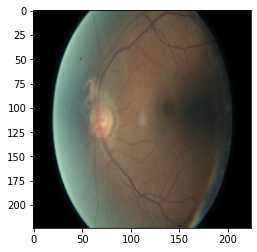

In [30]:
idx = np.random.randint(0, len(paths), size=1)[0]
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

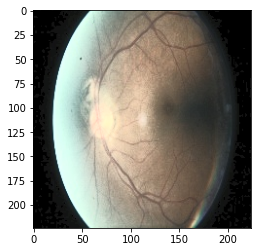

In [31]:
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [34]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['24583_left_1.jpeg', '9937_left_0.jpeg', '39291_right_0.jpeg']
[1, 0, 0]


<BarContainer object of 3 artists>

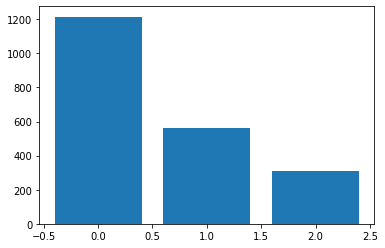

In [35]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [36]:
# Method 1: T
# clear graph
tf.keras.backend.clear_session()

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

for l in base_model.layers:
    l.trainable = False
model = models.Model(base_model.input, predictions)

In [ ]:
model.summary()

#### Prepare Data

In [37]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [38]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # preprocess by histogram equlization
        img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)
        # Applying equalize Hist operation on Y channel.
        y_eq = cv2.equalizeHist(y)
        img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [39]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:00<00:00, 623.42it/s]


In [40]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Training

In [41]:
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [42]:
logs = model.fit(x_train, y_train,
                batch_size=32,
                epochs=50,
                validation_data=(x_val, y_val))

Epoch 1/50
53/53 [==============================] - 19s 120ms/step - loss: 0.9905 - categorical_accuracy: 0.5326 - val_loss: 0.8591 - val_categorical_accuracy: 0.6268
Epoch 2/50
53/53 [==============================] - 4s 78ms/step - loss: 0.8331 - categorical_accuracy: 0.6238 - val_loss: 0.7619 - val_categorical_accuracy: 0.6579
Epoch 3/50
53/53 [==============================] - 4s 78ms/step - loss: 0.8359 - categorical_accuracy: 0.6290 - val_loss: 0.7324 - val_categorical_accuracy: 0.6722
Epoch 4/50
53/53 [==============================] - 4s 78ms/step - loss: 0.7685 - categorical_accuracy: 0.6440 - val_loss: 0.7173 - val_categorical_accuracy: 0.6794
Epoch 5/50
53/53 [==============================] - 4s 79ms/step - loss: 0.7455 - categorical_accuracy: 0.6598 - val_loss: 0.7103 - val_categorical_accuracy: 0.6818
Epoch 6/50
53/53 [==============================] - 4s 79ms/step - loss: 0.7251 - categorical_accuracy: 0.6800 - val_loss: 0.7161 - val_categorical_accuracy: 0.6962
Epoch 7/

#### Make Submission file

In [43]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,1
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,1
520,9717_right.jpeg,0
